# RO change over time

## Imports

In [1]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import src.XRO

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## Look at parameter change over time

Next, define a function to compute parameter changes over time

In [3]:
def get_ensemble_fits_over_time(
    data, model, ac_mask_idx, T_var="T_34", h_var="h", window_size=480, step_size=60
):
    """Get RO fits for each ensemble member as a function of time.
    Args:
        window_size: size of sliding window (units: months)
        step_size: how many months to slide the window between each calculation
    """

    ## Get number of timesteps in data
    n = len(data.time)

    ## empty list to hold results and dates
    fits_by_year = []
    start_dates = []

    ## loop through rolling windows
    for j, i in enumerate(tqdm.tqdm(np.arange(0, n - step_size, step_size))):

        ## make sure there's enough samples for robust estimate
        if (n - i) > (0.7 * window_size):

            ## get subset of data for fitting model
            data_subset = data.isel(time=slice(i, i + window_size))

            ## Get start date for subset
            start_dates.append(data_subset.time.isel(time=0))

            ## get parameter fit
            _, fits = src.utils.get_RO_ensemble(
                data_subset,
                T_var=T_var,
                h_var=h_var,
                model=model,
                ac_mask_idx=ac_mask_idx,
            )

            ## drop X,Y,time variables
            fits = fits.drop_vars(["X", "Y", "Yfit", "time"])
            fits_by_year.append(fits)

    ## convert from list to xarray
    start_dates = xr.concat(start_dates, dim="time")
    fits_by_year = xr.concat(fits_by_year, dim=start_dates)

    return fits_by_year

### Do the computation and save parameters to file

In [4]:
## specify save filepath
fits_save_fp = pathlib.Path(SAVE_FP / "fits_apr-30-2025.nc")

## specify args for model fit
kwargs = dict(
    T_var="T_34",
    h_var="h",
    model=src.XRO.XRO(ncycle=12, ac_order=3, is_forward=True),
    ac_mask_idx=[(1, 1)],
    window_size=480,
    step_size=60,
)


## Get fits for each period
if fits_save_fp.is_file():

    ## Load parameters if already computed
    fits = xr.open_dataset(fits_save_fp)

else:

    ## compute fits
    fits = get_ensemble_fits_over_time(Th, **kwargs)

    ## save to file
    fits.to_netcdf(fits_save_fp)

## get parameters from fits
params = kwargs["model"].get_RO_parameters(fits)

### Plot diagnostics

#### Ensemble-mean growth rate as a function of seasonal cycle and time

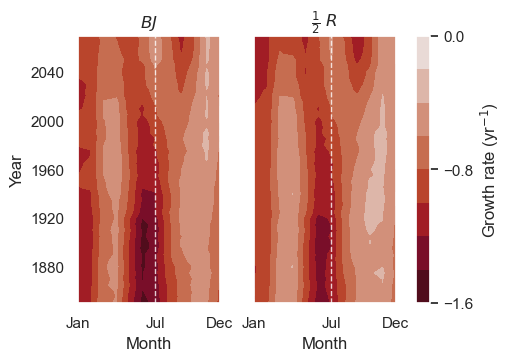

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3.5), layout="constrained")

## specify levels
levels = np.arange(-1.6, 0.2, 0.2)

## plot data
kwargs = dict(cmap="cmo.amp_r", levels=levels)
cp0 = axs[0].contourf(
    params.cycle, params.time, params["BJ_ac"].mean("member"), **kwargs
)

cp1 = axs[1].contourf(
    params.cycle, params.time, 0.5 * params["R"].mean("member"), **kwargs
)

## set ticks and add guideline
for ax in axs[:2]:
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.axvline(7, c="w", ls="--", lw=1, alpha=0.8)
    ax.set_xlabel("Month")

## add colorbar
cb = fig.colorbar(cp1, label=r"Growth rate (yr$^{-1}$)", ticks=[-1.6, -0.8, 0])

## label
axs[1].set_yticks([])
axs[0].set_ylabel("Year")
axs[0].set_title(r"$BJ$")
axs[1].set_title(r"$\frac{1}{2}~R$")

plt.show()

#### Plot annual max growth rate

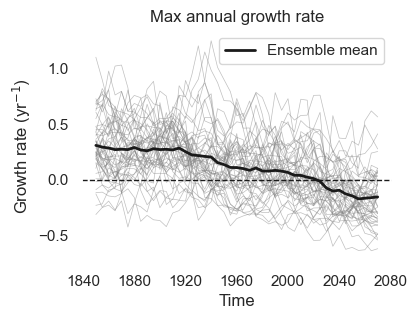

In [6]:
## param to plot
p = "epsilon"

fig, ax = plt.subplots(figsize=(4, 3))

## plot ensemble members
for i, m in enumerate(params.member.values):

    label = "Ensemble members" if (i == 50) else None

    ax.plot(
        params.time,
        params[p].sel(member=m).mean("cycle"),
        c="gray",
        alpha=0.5,
        lw=0.5,
    )

## plot ensemble mean
ax.plot(
    params.time,
    params[p].mean(["member", "cycle"]),
    c="k",
    lw=2,
    label="Ensemble mean",
)

## add labels and set plot style
ax.axhline(0, c="k", ls="--", lw=1)
ax.set_ylim([None, None])
ax.set_xlabel("Time")
ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
ax.set_title("Max annual growth rate")
ax.legend()

plt.show()